In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from Qatmosphere_2d import AtmosphereMaps

import sys
import yaml

sys.path.append('/home/laclavere/qubic/qubic/Pipeline')

import qubic
from qubic.lib.InstrumentModel.Qacquisition import QubicAcquisition
from qubic.lib.InstrumentModel.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene
from qubic.lib.Qsamplings import get_pointing

from qubic.scripts.MapMaking.src.FMM.model.planck_timeline import InputMaps

from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, BlockColumnOperator, BlockDiagonalOperator, DiagonalOperator, ReshapeOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

(786432, 3)


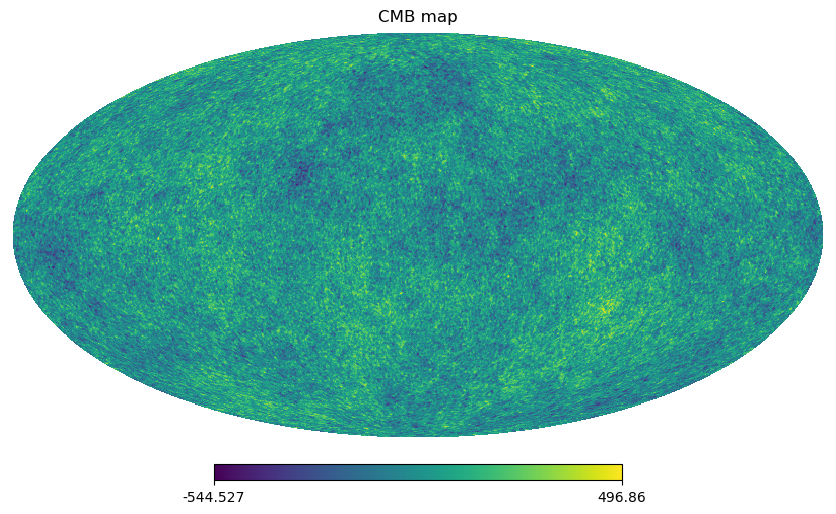

In [4]:
cmb_maps = InputMaps({'cmb':42}, [150e9], 1, params['nside']).m_nu[0]
print(cmb_maps.shape)
hp.mollview(cmb_maps[:, 0], title='CMB map')

786432


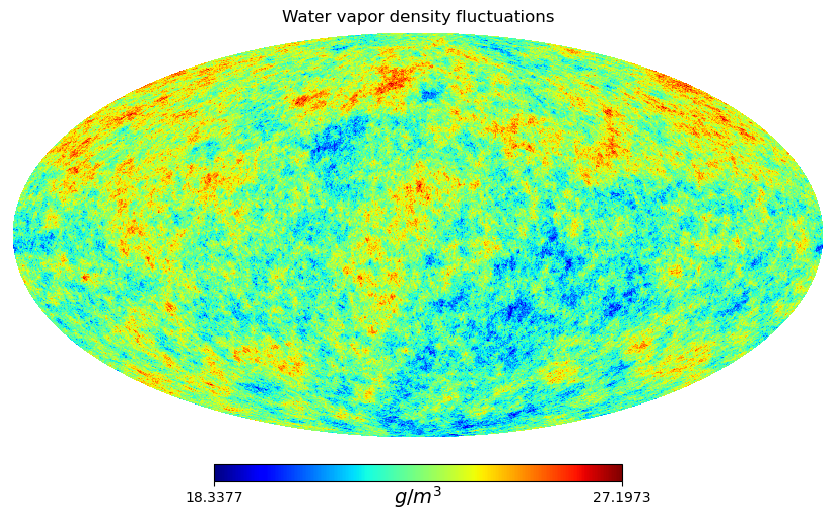

In [5]:
wv_fluctuations = atm.rho_map
print(wv_fluctuations.shape[0])
hp.mollview(wv_fluctuations, cmap='jet', title='Water vapor density fluctuations', unit=r'$g/m^{3}$')

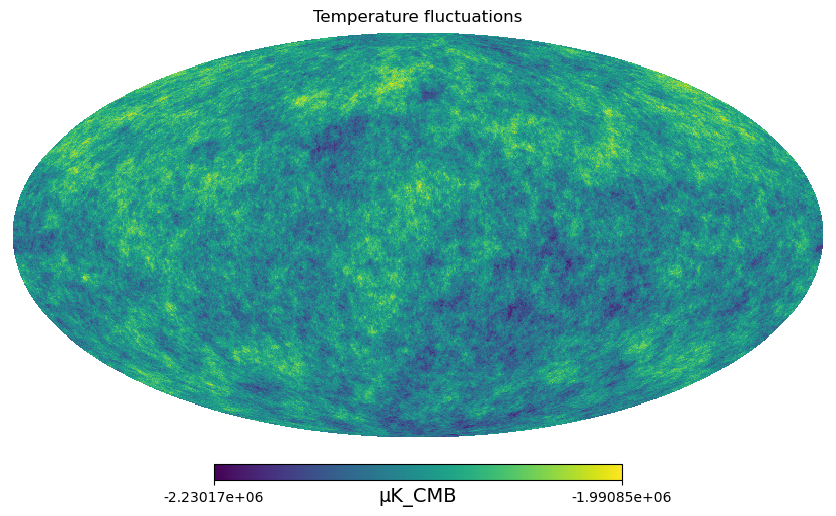

In [6]:
temp_fluctuations = np.zeros((wv_fluctuations.shape[0], 3))
temp_fluctuations[:, 0] = atm.get_temp_maps(wv_fluctuations)[0]
hp.mollview(temp_fluctuations[:, 0], title='Temperature fluctuations', unit='µK_CMB')

In [7]:
q_instrument = QubicInstrument(qubic_dict)
q_sampling = get_pointing(qubic_dict)
q_scene = QubicScene(qubic_dict)

q_acquisition = QubicAcquisition(q_instrument, q_sampling, q_scene, qubic_dict)

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.


In [8]:
coverage = q_acquisition.get_coverage()

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.


In [9]:
H_qubic = q_acquisition.get_operator()
R_qubic = ReshapeOperator(H_qubic.shapeout, H_qubic.shape[0])
invN_qubic = R_qubic(q_acquisition.get_invntt_operator(False, False)(R_qubic.T))
d_qubic = H_qubic(temp_fluctuations + cmb_maps).ravel()

Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.


In [18]:
print(temp_fluctuations.shape)
print(cmb_maps.shape)

(786432, 3)
(786432, 3)


In [10]:
H_planck = ReshapeOperator(temp_fluctuations.shape, temp_fluctuations.ravel().shape)
invN_planck = DiagonalOperator(np.ones(H_planck.shapeout))
d_planck = H_planck(temp_fluctuations + cmb_maps)

In [11]:
if params['external_data']:
    H = BlockColumnOperator([R_qubic(H_qubic), H_planck], axisout=0)
    invN = BlockDiagonalOperator([invN_qubic, invN_planck], axisout=0)
    d = np.concatenate((d_qubic, d_planck))
else:
    H = R_qubic(H_qubic)
    invN = invN_qubic
    d = d_qubic

In [12]:
A = H.T * invN * H
b = H.T * invN * d.flatten()
x0 = temp_fluctuations*0
true_maps = temp_fluctuations + cmb_maps

In [13]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=50,
    disp=True,
    M=None,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

2
 Iter     Tol      time
   1: 5.6033e-01 0.38382 [879027.36109833 877674.32557491 864741.94391746 ... 876391.78243799
 880951.69814908 873557.92680567]
2
   2: 2.0343e-01 0.31813 [83639.09846651 83538.64288805 82267.66882754 ... 83266.60662435
 83665.44946689 82833.82052793]
2
   3: 7.1009e-02 0.31827 [9837.04892473 9822.80053379 9666.59670476 ... 9712.70814289 9734.18452235
 9635.91894135]
2
   4: 1.7018e-02 0.32588 [1329.32060329 1331.78624023 1304.08651797 ... 1287.12256023 1276.10087084
 1278.9637808 ]
2
   5: 4.2964e-03 0.25860 [415.78373601 422.00378716 409.25957977 ... 390.0614977  383.90720503
 388.42727618]
2
   6: 1.9443e-03 0.23278 [203.02675809 208.88796366 201.19900991 ... 188.50281209 187.62467465
 187.50726948]
2
   7: 1.0456e-03 0.23389 [83.13632173 86.18143954 82.96867082 ... 76.4362344  76.88442491
 74.91560618]
2
   8: 4.4221e-04 0.24054 [27.1162397  28.07086376 27.15536292 ... 24.4988154  24.9149705
 23.29882565]
2
   9: 1.6115e-04 0.26420 [7.92791473 8.16031737 7

Text(0, 0.5, 'Convergence')

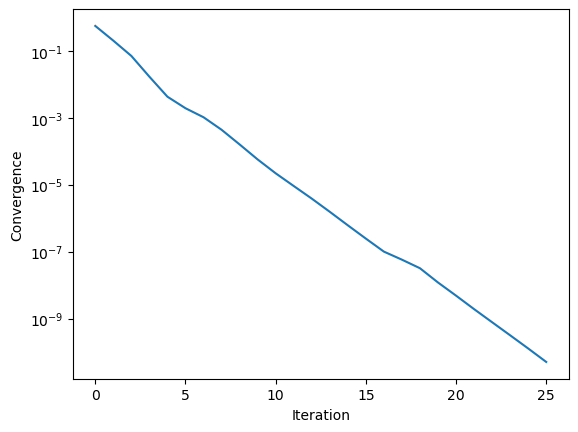

In [14]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

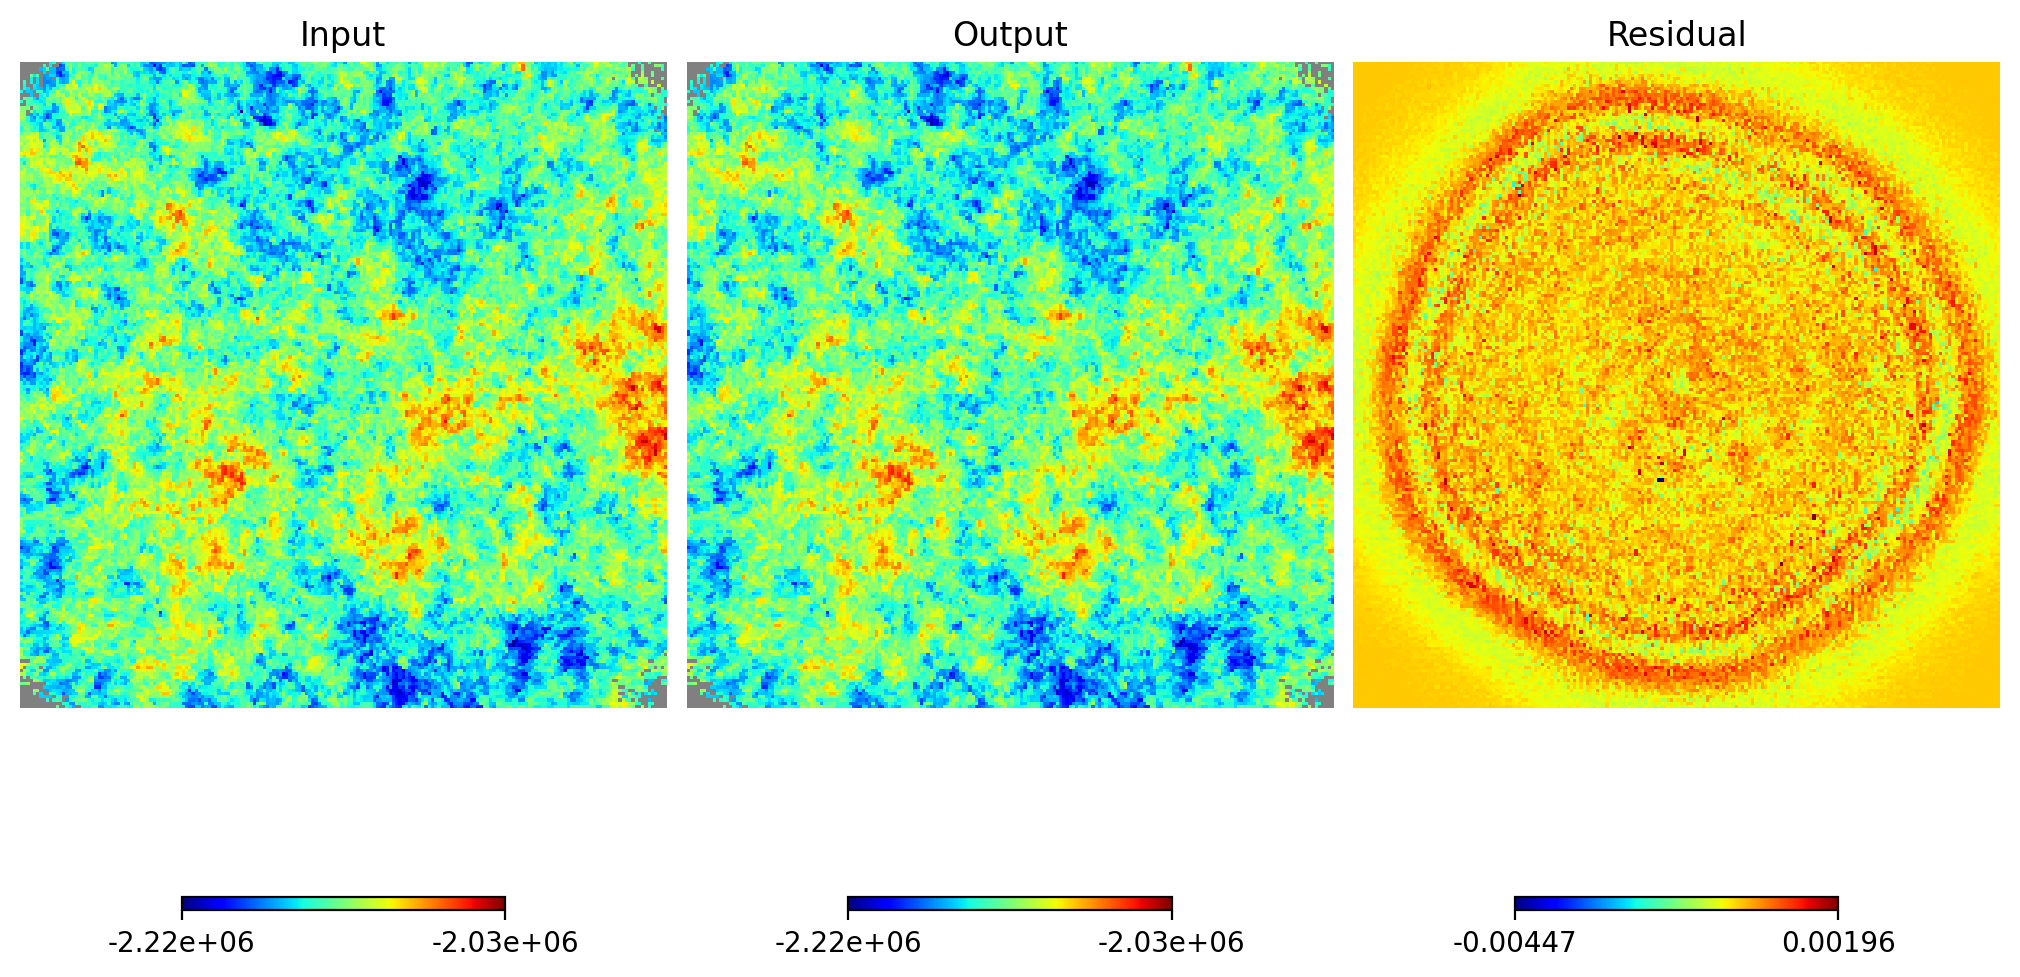

In [15]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

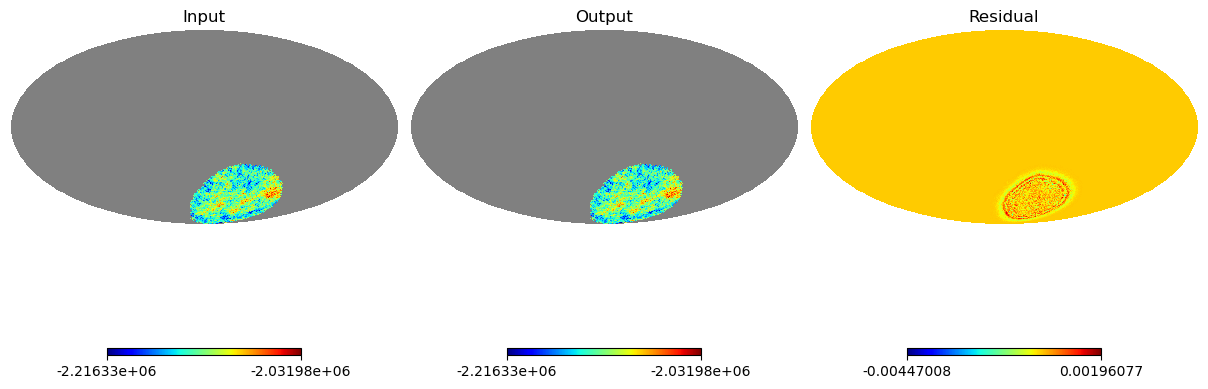

In [16]:
plt.figure(figsize=(12, 25))
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.mollview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k), title='Input', notext=True)
hp.mollview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k+1), title='Output', notext=True)
hp.mollview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

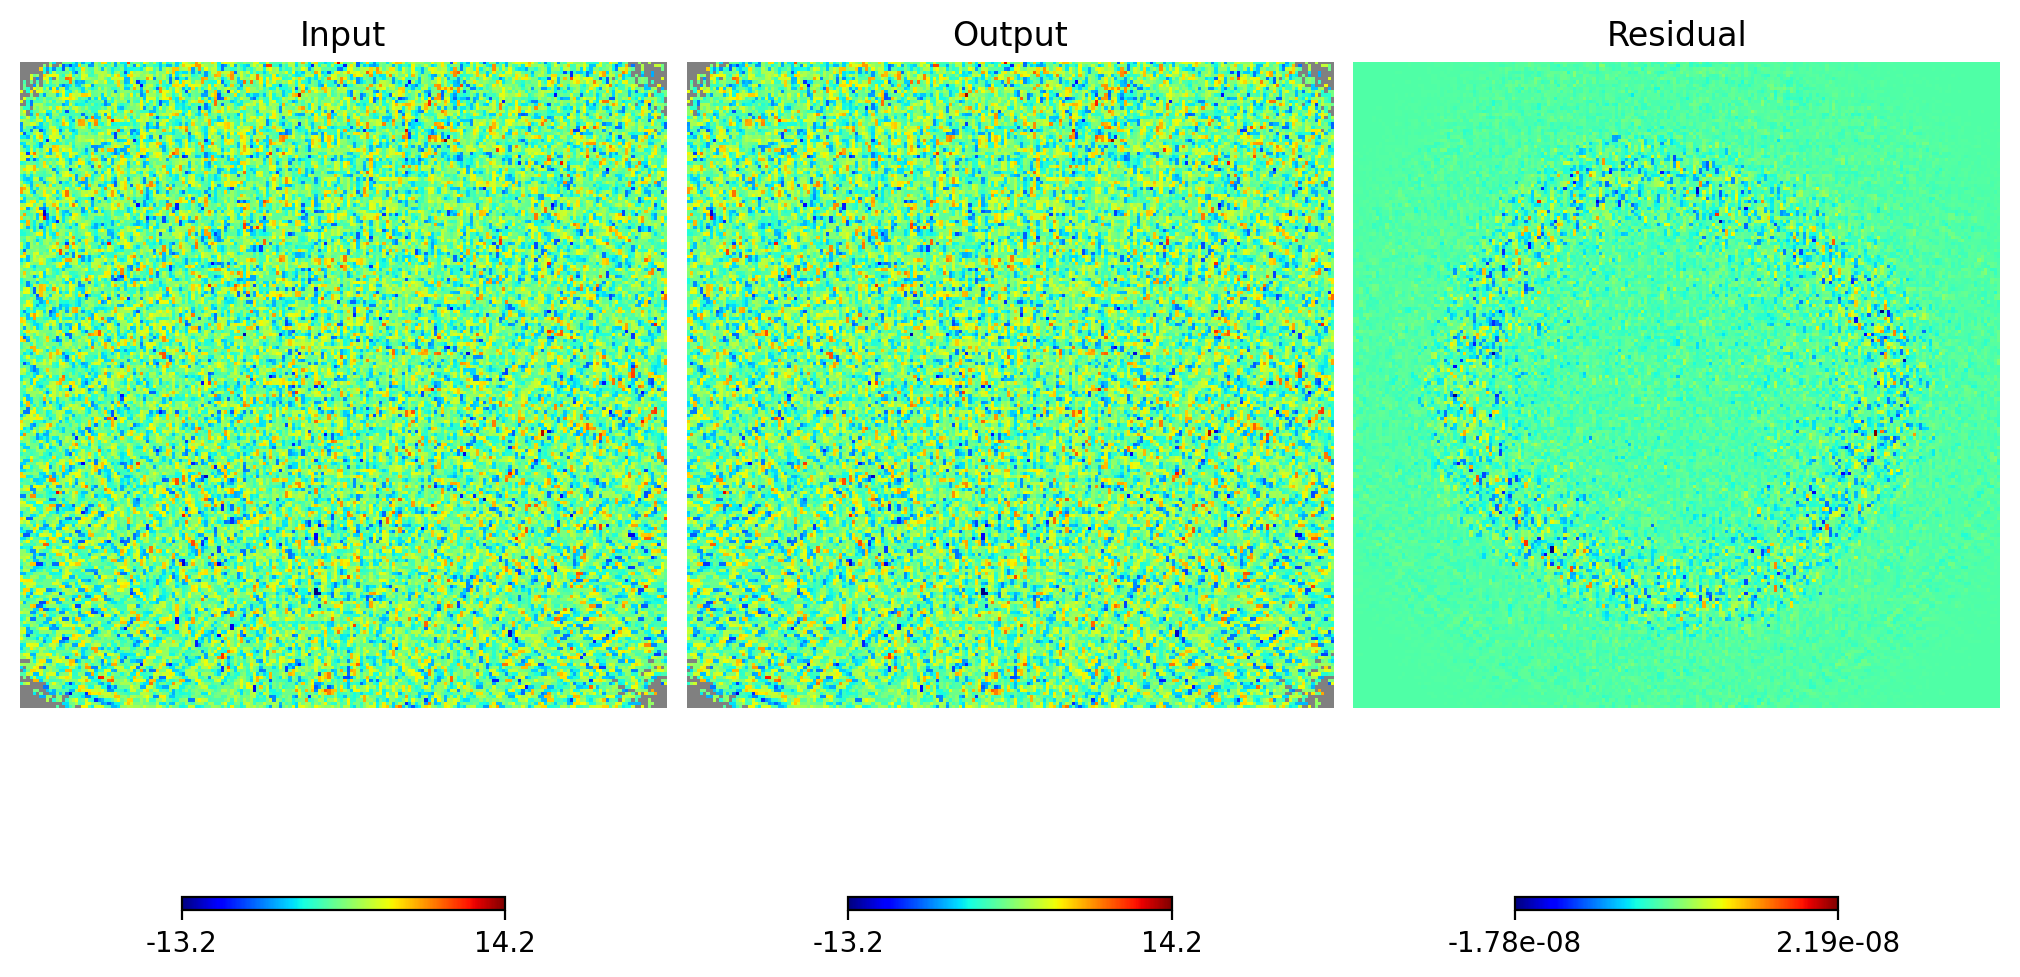

In [17]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3